<a href="https://colab.research.google.com/github/LD-Shell/-STT997-Deep-Generative-Model/blob/main/ml/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression & Model Assessment

Regression is supervised learning with continuous (or sometimes discrete) labels. You are given labeled data consisting of features and labels $\{\vec{x}_i, y_i\}$. The goal is to find a function that describes their relationship, $\hat{f}(\vec{x}) = \hat{y}$. A more formal discussion of the concepts discussed here can be found in Chapter 3 of Bishop's Pattern Recognition and Machine Learning{cite}`bishop2006pattern`.

```{admonition} Audience & Objectives
This lecture introduces some probability theory, especially expectations. You can get a refresher of [probability of random variables](https://whitead.github.io/numerical_stats/) and/or [expectations](https://whitead.github.io/numerical_stats/unit_4/lectures/lecture_2.pdf). Recall an expectation is $E[x] = \sum P(x)x$ and variance is $E[\left(x - E[x]\right)^2]$. We also use and discuss [linear regression techniques](https://nbviewer.jupyter.org/github/whitead/numerical_stats/blob/master/unit_12/lectures/lecture_1.ipynb#Extending-Least-Squares-to-Multiple-Dimensions-in-Domain---OLS-ND). After completing this chapter, you should be able to:

  * Perform multi-dimensional regression with a loss function
  * Understand how to and why we batch
  * Understand splitting of data
  * Reason about model bias and model variance
  * Assess model fit and generalization error
```


In [ ]:
%%capture
!pip install dmol-book

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages.

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell.

```
!pip install dmol-book
```

If you find install problems, you can get the latest working versions of packages used in [this book here](https://github.com/whitead/dmol-book/blob/main/package/setup.py)

````

As usual, the code below sets-up our imports.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
import jax
pd.set_option("display.max_columns", None)
# import dmol

In [2]:
# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:] # slice from index of MolWt till the end
display(list(soldata.columns))
display(soldata.info())

['ID',
 'Name',
 'InChI',
 'InChIKey',
 'SMILES',
 'Solubility',
 'SD',
 'Ocurrences',
 'Group',
 'MolWt',
 'MolLogP',
 'MolMR',
 'HeavyAtomCount',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumValenceElectrons',
 'NumAromaticRings',
 'NumSaturatedRings',
 'NumAliphaticRings',
 'RingCount',
 'TPSA',
 'LabuteASA',
 'BalabanJ',
 'BertzCT']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms       9982 non-null   f

None

## Overfitting

We'll be working again with the AqSolDB{cite}`Sorkun2019` dataset. It has about 10,000 unique compounds with measured solubility in water (label) and 17 molecular descriptors (features). We need to create a better assessment of our supervised ML models. The goal of our ML model is to predict solubility of new unseen molecules. Therefore, to assess we should test on unseen molecules. We will split our data into two subsets: **training data** and **testing data**. Typically this is done with an 80%/20%, so that you train on 80% of your data and test on the remaining 20%. In our case, we'll just do 50%/50% because we have plenty of data and thus do not need to take 80% for training. We'll be using a subset, 50 molecules chosen randomly, rather than the whole dataset. So we'll have 25 training molecules and 25 testing molecules.

Let's begin by seeing what effect the split of train/test has on our linear model introduced in the previous chapter.

In [ ]:
# Get 50 points and split into train/test
sample = soldata.sample(50, replace=False, random_state=0)
train = sample.iloc[:25].copy()
test = sample.iloc[25:].copy()

# standardize the features using only train
test[feature_names] -= train[feature_names].mean()
test[feature_names] /= train[feature_names].std() # Not so cool reassigning same variables
train[feature_names] -= train[feature_names].mean()
train[feature_names] /= train[feature_names].std()

# convert from pandas dataframe to numpy arrays both training and test data
x = train[feature_names].to_numpy(dtype="float64")
y = train["Solubility"].to_numpy(dtype="float64")
test_x = test[feature_names].to_numpy(dtype="float64")
test_y = test["Solubility"].to_numpy(dtype="float64")

In [ ]:
display(test.head(5))
display(test_y)

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
3009,A-5040,"bis(2,4,4-trimethylpentyl)phosphinic acid","InChI=1S/C16H35O2P/c1-13(9-15(3,4)5)11-19(17,1...",QUXFOKCUIZCKGS-UHFFFAOYSA-N,CC(CC(C)(C)C)C[P](O)(=O)CC(C)CC(C)(C)C,-4.366128,0.000000,1,G1,0.308982,1.612791,0.592909,0.249821,-0.862911,0.000000,-0.416609,0.901631,0.577426,-1.083618,-0.457903,-0.499549,-1.214537,-0.343860,0.280914,2.095131,-0.409045
4580,B-1316,"benzoic acid, 2-benzoyl-, methyl ester",InChI=1S/C15H12O3/c1-18-15(17)13-10-6-5-9-12(1...,NQSMEZJWJJVYOI-UHFFFAOYSA-N,COC(=O)c1ccccc1C(=O)c2ccccc2,-3.477600,0.151313,3,G5,-0.083778,0.278126,0.062644,0.140251,-0.078446,-0.960769,-0.416609,-0.122950,0.008749,0.923082,-0.457903,-0.499549,0.266606,-0.200711,0.011745,0.186119,0.286090
6832,B-4089,"2,3'-pcb",InChI=1S/C12H8Cl2/c13-10-5-3-4-9(8-10)11-6-1-2...,ZHBBDTRJIVXKEX-UHFFFAOYSA-N,Clc1cccc(c1)c2ccccc2Cl,-5.585100,0.000000,1,G1,-0.218085,1.246119,-0.103518,-0.298033,-1.255143,-0.960769,-0.722938,-0.806004,-0.428695,0.923082,-0.457903,-0.499549,0.266606,-1.223509,-0.197173,0.277226,-0.008837
4804,B-1591,glyphosphate,"InChI=1S/C3H8NO5P/c5-3(6)1-4-2-10(7,8)9/h4H,1-...",XDDAORKBJWWYJS-UHFFFAOYSA-N,OC(=O)CNC[P](O)(O)=O,-1.206900,0.000000,1,G1,-0.641056,-1.655882,-0.950438,-0.736316,-0.078446,2.882307,0.808711,0.218577,-0.647417,-1.083618,-0.457903,-0.499549,-1.214537,1.296579,-0.829081,1.118035,-0.693703
9730,F-1207,5-bromo-6-(pyrrolidin-1-ylmethyl)-1H-pyrimidin...,InChI=1S/C9H12BrN3O2/c10-7-6(5-13-3-1-2-4-13)1...,ACVNMTOONYGQIK-UHFFFAOYSA-N,O=C1NC(=O)C(Br)=C(CN2CCCC2)N1,-1.780000,0.000000,1,G1,0.181298,-0.851431,-0.161336,-0.188462,-0.078446,0.960769,0.502381,-0.464477,-0.166229,-0.080268,0.582786,0.392503,0.266606,0.402780,-0.170106,-0.005337,0.014002


array([-4.36612847, -3.4776    , -5.5851    , -1.2069    , -1.78      ,
       -2.8271    , -9.29      , -1.3798    , -2.6172    , -6.1119    ,
       -2.22444579, -3.1079    , -3.36      , -2.46500776, -1.8841    ,
       -2.8927    , -2.75      ,  0.76      , -2.63      , -3.9033    ,
       -2.5295    , -5.49512024, -1.375     , -1.8433    , -0.57673192])

We will again use a linear model,  $ \hat{y} = \vec{w}\vec{x} + b $. One change we'll make is using the [@jit](https://jax.readthedocs.io/en/latest/jax.html#jax.jit) decorator from `jax`. This decorator will tell `jax` to inspect our function, simplify it, and compile it to run quickly on a GPU (if available) or CPU. The rest of our work is the same as the previous chapter. We begin with defining our loss, which is mean squared error (MSE) again.

```{margin}
A decorator is a Python-specific syntax that modifies how a function behaves. It is
indicated with the `@` symbol. Examples include caching results, compiling the function, running
it in parallel, and timing its execution.
```

In [ ]:
# define our loss function, MSE
# @jax.jit
# def loss(w, b, x, y):
#     return jnp.mean((y - jnp.dot(x, w) - b) ** 2)


# loss_grad = jax.grad(loss, (0, 1)) #dL/dw and dL/db
# w = np.random.normal(size=x.shape[1])
# b = 0.0
# loss_grad(w, b, x, y)
x = jnp.asarray(x)
y = jnp.asarray(y)

@jax.jit
def loss(w, b, x, y):
    pred = x @ w + b
    return jnp.mean((y - pred) ** 2)

loss_grad = jax.jit(jax.grad(loss, (0, 1)))

key = jax.random.key(0)
w = jax.random.normal(key, (x.shape[1],))
b = 0.0

dw, db = loss_grad(w, b, x, y)
print(dw)
print(db)

[ 6.089065    8.537616    7.0528703   6.139058    0.7106287  -2.802421
  1.705684    6.0760536   6.698109    2.973842    3.6174335   2.8933935
  4.5970526  -0.34123844  5.7030416   0.79170287  3.9552572 ]
5.772167


Now we will train our model, again using gradient descent. This time we will not batch, since our training data only has 25 points. Can you see what the learning rate is? Why is it so different from the last chapter when we used the whole dataset?

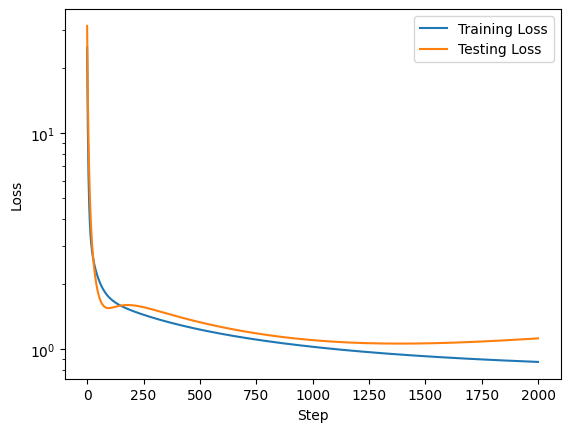

In [ ]:
loss_progress = []
test_loss_progress = []
eta = 0.05
for i in range(2000):
    grad = loss_grad(w, b, x, y)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss(w, b, x, y))
    test_loss_progress.append(loss(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.yscale("log")
plt.legend()
plt.ylabel("Loss")
plt.show()

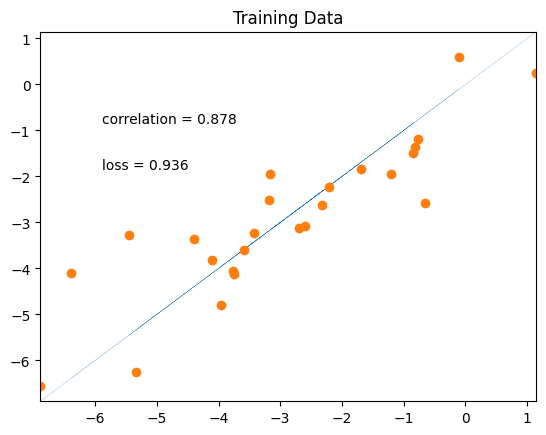

In [ ]:
yhat = x @ w + b # Model's Solubility Predictions
plt.plot(y, y, ":", linewidth=0.2) # Perfect line, ideal predictions
plt.plot(y, x @ w + b, "o")
plt.xlim(min(y), max(y))
plt.ylim(min(y), max(y))
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((y - yhat)**2)):.3f}")
plt.title("Training Data")
plt.show()

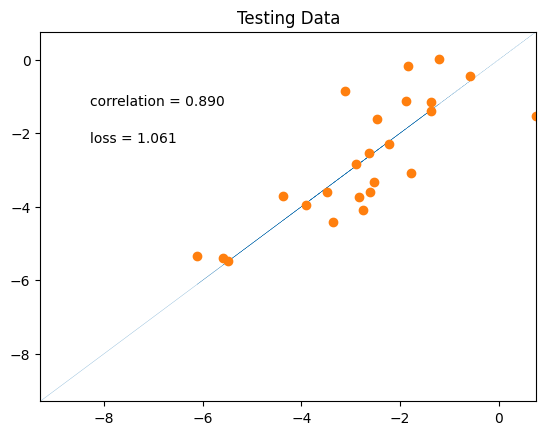

In [ ]:
yhat = test_x @ w + b
plt.plot(test_y, test_y, ":", linewidth=0.2)
plt.plot(test_y, yhat, "o")
plt.xlim(min(test_y), max(test_y))
plt.ylim(min(test_y), max(test_y))
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

We've plotted above the loss on our training data and testing data. The loss on training goes down after each step, as we would expect for gradient descent. However, the testing loss goes down and then starts to go back up. This is called **overfitting**. This is one of the key challenges in ML and we'll often be discussing it.

Overfitting is a result of training for too many steps or with too many parameters, resulting in our model learning the **noise** in the training data. The noise is specific for the training data and when computing loss on the test data there is poor performance.

To understand this, let's first define noise. Assume that there is a "perfect" function $f(\vec{x})$ that can compute labels from features. Our model is an estimate $\hat{f}(\vec{x})$ of that function. Even $f(\vec{x})$ will not reproduce the data exactly because our features do not capture everything that goes into solubility and/or there is error in the solubility measurements themselves. Mathematically,

\begin{equation}
    y = f(\vec{x}) + \epsilon
\end{equation}

where $\epsilon$ is a random number with mean 0 and unknown standard deviation $\sigma$. $\epsilon$ is the noise. When fitting our function, $\hat{f}(\vec{x})$, the noise is fixed because our labels $y$ are fixed. That means we can accidentally learn to approximate the sum of $f(\vec{x})$ and the noise ${\epsilon_i}$ instead of only capturing $f(\vec{x})$. The noise is random and uncorrelated with solubility. When we move to our testing dataset, this noise changes because we have new data and our model's effort to reproduce noise is useless because the new data has new noise. This leads to worse performance.


Overfitting arises when three things happen: **you have noise, you have extra features or some part of your features are not correlated with the labels, and your training has converged (your model fit is at the global minimum)**. This last one is what we saw above. Our model wasn't overfit after about 100 steps (the training and testing loss were both decreasing), but then they starting going in opposite directions. Let's see how these things interplay to lead to overfitting in an example where we can exactly control the features and noise.

### Overfitting with Synthetic Data

We'll explore overfitting in a synthetic example. Our real function we're trying to learn will be:

\begin{equation}
 f(x) = x^3 - x^2 + x - 1
\end{equation}

which we can rewrite as a linear model:

\begin{equation}
  f(\vec{x}) = \vec{w}\cdot\vec{x} = [1, -1, 1, -1]\cdot[x^3, x^2, x, 1]
\end{equation}
where our features are $[x^3, x^2, x, 1]$. To do our split, we'll take the **positive points as training data** and the **negative as testing data**. To avoid the issue of convergence, we will use least squares to fit these models instead of gradient descent.

Let's establish a benchmark. How well can a model do without noise? We'll use **10 training data points** and **10 testing data points**. We'll put our testing data in the center of the polynomial.

Expand the Python cells below to see how this is implemented.

In [ ]:
# generate data from polynomial
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix
syn_features = np.vstack([syn_x**3, syn_x**2, syn_x, np.ones_like(syn_x)]).T
syn_labels = syn_x**3 - syn_x**2 + syn_x - 1
display(syn_x)
display(syn_features)
display(syn_labels)

array([-3.        , -2.68421053, -2.36842105, -2.05263158, -1.73684211,
       -1.42105263, -1.10526316, -0.78947368, -0.47368421, -0.15789474,
        0.15789474,  0.47368421,  0.78947368,  1.10526316,  1.42105263,
        1.73684211,  2.05263158,  2.36842105,  2.68421053,  3.        ])

array([[-2.70000000e+01,  9.00000000e+00, -3.00000000e+00,
         1.00000000e+00],
       [-1.93396997e+01,  7.20498615e+00, -2.68421053e+00,
         1.00000000e+00],
       [-1.32854644e+01,  5.60941828e+00, -2.36842105e+00,
         1.00000000e+00],
       [-8.64834524e+00,  4.21329640e+00, -2.05263158e+00,
         1.00000000e+00],
       [-5.23939350e+00,  3.01662050e+00, -1.73684211e+00,
         1.00000000e+00],
       [-2.86966030e+00,  2.01939058e+00, -1.42105263e+00,
         1.00000000e+00],
       [-1.35019682e+00,  1.22160665e+00, -1.10526316e+00,
         1.00000000e+00],
       [-4.92054235e-01,  6.23268698e-01, -7.89473684e-01,
         1.00000000e+00],
       [-1.06283715e-01,  2.24376731e-01, -4.73684211e-01,
         1.00000000e+00],
       [-3.93643388e-03,  2.49307479e-02, -1.57894737e-01,
         1.00000000e+00],
       [ 3.93643388e-03,  2.49307479e-02,  1.57894737e-01,
         1.00000000e+00],
       [ 1.06283715e-01,  2.24376731e-01,  4.73684211e-01,
      

array([-40.        , -30.22889634, -22.26330369, -15.91427322,
       -10.9928561 ,  -7.31010351,  -4.67706663,  -2.90479662,
        -1.80434466,  -1.18676192,  -0.86309958,  -0.64440881,
        -0.34174078,   0.23385333,   1.27132235,   2.9596151 ,
         5.48768042,   9.04446712,  13.81892404,  20.        ])

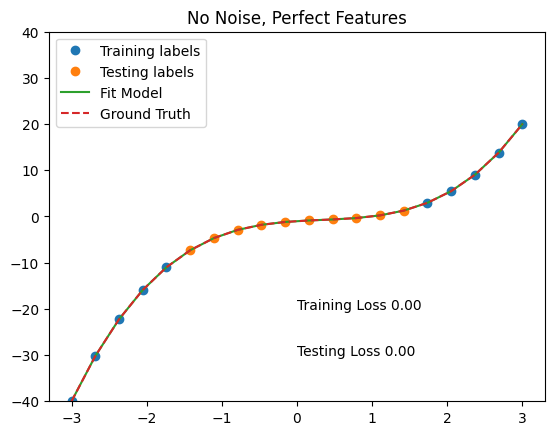

In [ ]:
# split data into train/test
indices = list(range(0, N // 4)) + list(range(3 * N // 4, N)) # They took the first quater and fourth quater for training
test_indices = list(range(N // 4, 3 * N // 4)) # Second and third quater for test
train_x = syn_features[indices]
train_y = syn_labels[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

# fit using numpy least squares method.
w, *_ = np.linalg.lstsq(train_x, train_y) # Return only the weights, no residuals, ranks, etc

# plotting code
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend()
plt.title("No Noise, Perfect Features")
plt.show()

There is no overfitting and the regression is quite accurate without noise. Now we'll add noise to both the training labels.

In [ ]:
train_y = train_y + np.random.normal(scale=5, size=train_y.shape) # random gaussian noise with std 5

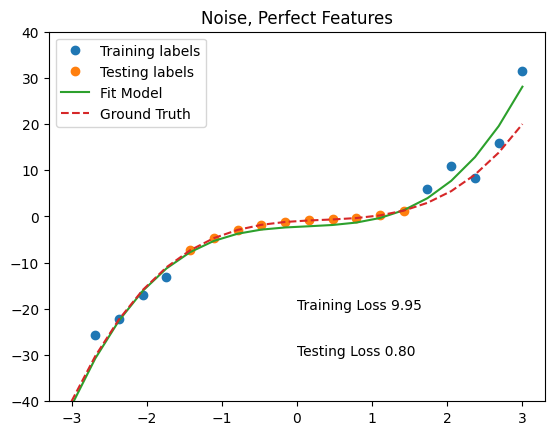

In [ ]:
w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend()
plt.title("Noise, Perfect Features")
plt.show()

Adding noise reduces the accuracy on the training data. **The testing labels have no noise and the model is not overfit**, so the accuracy is good for the testing loss.

Now we'll try adding redundant features. Our new features will be $[x^6, x^5, x^4, x^3, x^2, x, 1]$. Still less than our data point number but not all features are necessary to fit the labels.

In [ ]:
syn_features = np.vstack([syn_x**i for i in range(7)]).T # Introduce 3 additional redundant features and stacks them into shape (20, 7)
syn_features

array([[ 1.00000000e+00, -3.00000000e+00,  9.00000000e+00,
        -2.70000000e+01,  8.10000000e+01, -2.43000000e+02,
         7.29000000e+02],
       [ 1.00000000e+00, -2.68421053e+00,  7.20498615e+00,
        -1.93396997e+01,  5.19118254e+01, -1.39342268e+02,
         3.74023983e+02],
       [ 1.00000000e+00, -2.36842105e+00,  5.60941828e+00,
        -1.32854644e+01,  3.14655735e+01, -7.45237266e+01,
         1.76503563e+02],
       [ 1.00000000e+00, -2.05263158e+00,  4.21329640e+00,
        -8.64834524e+00,  1.77518665e+01, -3.64380419e+01,
         7.47938754e+01],
       [ 1.00000000e+00, -1.73684211e+00,  3.01662050e+00,
        -5.23939350e+00,  9.09999923e+00, -1.58052618e+01,
         2.74512442e+01],
       [ 1.00000000e+00, -1.42105263e+00,  2.01939058e+00,
        -2.86966030e+00,  4.07793832e+00, -5.79496498e+00,
         8.23495024e+00],
       [ 1.00000000e+00, -1.10526316e+00,  1.22160665e+00,
        -1.35019682e+00,  1.49232280e+00, -1.64940941e+00,
         1.8230314

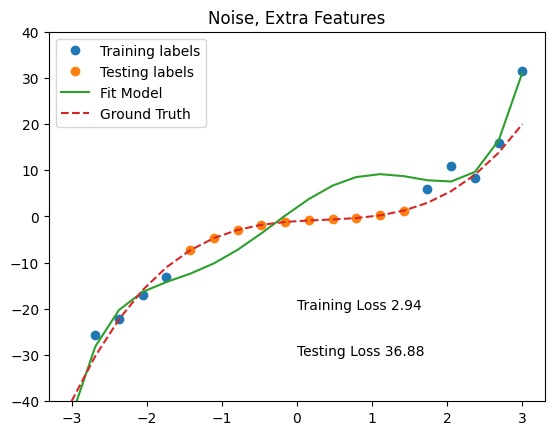

In [ ]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend(loc="upper left")
plt.title("Noise, Extra Features")
plt.show()

This is an overfit model. The training loss went down (note the noise was the same in the previous two examples), but at the expense of a large increase in testing loss. This wasn't possible in the previous example because over-fitting to noise wasn't feasible when each feature was necessary to capture the correlation with the labels.

Let's see an example **where the feature number is the same but they aren't perfectly correlated** with labels, meaning we cannot match the labels even if there was no noise.

In [ ]:
syn_features = np.vstack(
    [syn_x**2, syn_x, np.exp(-(syn_x**2)), np.cos(syn_x), np.ones_like(syn_x)]
).T

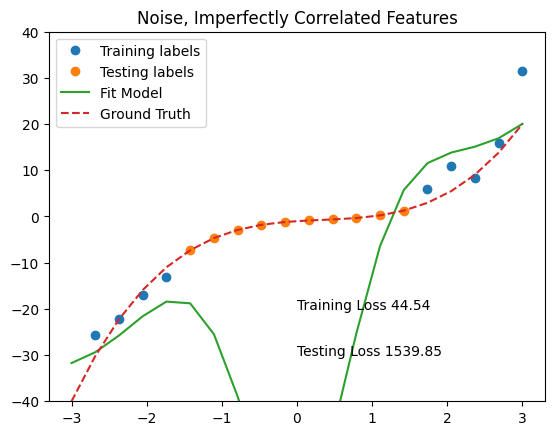

In [ ]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend(loc="upper left")
plt.title("Noise, Imperfectly Correlated Features")
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
# redo
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix
syn_labels = syn_x**3 - syn_x**2 + syn_x - 1 + np.random.normal(size=N)
syn_features = np.vstack([syn_x]).T

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
from myst_nb import glue

L = 250
test_vals = np.empty((N, L))
test_vals[:] = np.nan
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for i in range(L):
    indices = np.random.choice(range(N), size=N // 2)
    test_indices = list(set(range(N)) - set(indices))
    train_x = syn_features[indices]
    train_y = syn_labels[indices]
    test_x = syn_features[test_indices]
    test_y = syn_labels[test_indices]
    w, *_ = np.linalg.lstsq(train_x, train_y)
    test_vals[test_indices, i] = jnp.dot(test_x, w)
    axs[1].plot(syn_x, jnp.dot(syn_features, w), color="C0", alpha=0.7, linewidth=0.1)
axs[1].plot(
    syn_x,
    jnp.dot(syn_features, w),
    color="C0",
    alpha=0.7,
    linewidth=1,
    label="Predicted",
)
axs[0].plot(syn_x, jnp.dot(syn_features, w), color="C0", label="Predicted")
axs[0].plot(syn_x[test_indices], test_y, "o", color="C1", label="Test Data")
axs[0].plot(syn_x[indices], train_y, "o", color="C4", label="Train Data")
axs[1].set_ylim(-40, 40)
axs[0].set_ylim(-40, 40)
axs[1].plot(
    syn_x, syn_x**3 - syn_x**2 + syn_x - 1, "--", label="Ground Truth", color="C1"
)
axs[0].plot(
    syn_x, syn_x**3 - syn_x**2 + syn_x - 1, "--", label="Ground Truth", color="C1"
)
axs[1].legend()
axs[0].legend()
axs[0].set_title("Single Model Fit")
axs[1].set_title(f"Model Fit on {L} Training/Test Splits")

plt.tight_layout()
glue("low_var", plt.gcf(), display=False)
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
syn_features = np.vstack([syn_x**i for i in range(7)]).T
L = 1000
test_vals = np.empty((N, L))
test_vals[:] = np.nan
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for i in range(L):
    indices = np.random.choice(range(N), size=N // 2)
    test_indices = list(set(range(N)) - set(indices))
    train_x = syn_features[indices]
    train_y = syn_labels[indices]
    test_x = syn_features[test_indices]
    test_y = syn_labels[test_indices]
    w, *_ = np.linalg.lstsq(train_x, train_y)
    test_vals[test_indices, i] = jnp.dot(test_x, w)
    axs[1].plot(
        syn_x[test_indices], jnp.dot(test_x, w), color="C0", alpha=0.7, linewidth=0.1
    )
axs[1].plot(
    syn_x,
    jnp.dot(syn_features, w),
    color="C0",
    alpha=0.7,
    linewidth=1,
    label="Predicted",
)
axs[1].plot(
    syn_x,
    np.nanmedian(test_vals, axis=1),
    color="C2",
    alpha=1.0,
    linewidth=2,
    label="Median on Test",
)
axs[0].plot(syn_x, jnp.dot(syn_features, w), color="C0", label="Predicted")
axs[0].plot(syn_x[test_indices], test_y, "o", color="C1", label="Test Data")
axs[0].plot(syn_x[indices], train_y, "o", color="C4", label="Train Data")
axs[1].set_ylim(-40, 40)
axs[0].set_ylim(-40, 40)
axs[1].plot(
    syn_x, syn_x**3 - syn_x**2 + syn_x - 1, "--", label="Ground Truth", color="C1"
)
axs[0].plot(
    syn_x, syn_x**3 - syn_x**2 + syn_x - 1, "--", label="Ground Truth", color="C1"
)
axs[1].legend()
axs[0].legend()
axs[0].set_title("Single Model Fit")
axs[1].set_title(f"Model Fit on {L} Training/Test Splits")
plt.tight_layout()
glue("high_var", plt.gcf(), display=False)
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
F = 6
bias = []
var = []
test_error = []
L = 2500
for f in range(1, F):
    syn_features = np.vstack([syn_x**i for i in range(f)]).T
    test_vals = np.empty((L, N))
    test_vals[:] = np.nan
    for i in range(L):
        indices = np.random.choice(range(N), size=N // 2)
        test_indices = list(set(range(N)) - set(indices))
        train_x = syn_features[indices]
        train_y = syn_labels[indices]
        test_x = syn_features[test_indices]
        test_y = syn_labels[test_indices]
        w, *_ = np.linalg.lstsq(train_x, train_y)
        test_vals[i, test_indices] = np.clip(np.dot(test_x, w), -1000, 1000)
    ed = np.nanmean(test_vals, axis=0)
    bias.append(np.mean((ed - (syn_x**3 - syn_x**2 + syn_x - 1)) ** 2))
    test_error.append(np.nanmean((test_vals - syn_labels) ** 2))
    var.append(np.nanmean((ed - test_vals) ** 2))
plt.plot(range(1, F), bias, label="bias$^2$")
plt.plot(range(1, F), var, label="variance")
plt.plot(range(1, F), test_error, label="test error")
plt.xlabel("Feature Number")
plt.legend()
glue("bv", plt.gcf(), display=False)
plt.show()

It's arguable if this is overfitting. Yes, **the testing loss is high but it could be argued it's more to do with the poor feature choice**. In any case, even though our parameter number is less than the clear cut case above, there is still left over variance in our features which can be devoted to fitting noise.


Would there overfitting with imperfectly correlated features if we had no noise? Justify your answer

```{admonition} Answer
:class: dropdown
Probably not - although features might diverge or become zero where the test data is located, we cannot be overfitting to noise if there is no noise.
```


### Overfitting Conclusion

* Overfitting is inevitable in real data because we cannot avoid noise and rarely have the perfect features.
* Overfitting can be assessed by splitting our data into a train and test split, which mimics how we would use the model (i.e., on unseen data).
* Overfitting is especially affected by having too many features or features that don't correlate well with the labels.
* **We can identify overfitting from a loss curve which shows the testing loss rising while training loss is decreasing.**

## Exploring Effect of Feature Number

We've seen that overfitting is sensitive to the number and choice of features. Feature selection is a critical decision in supervised learning. We'll return to the solubility dataset to discuss this. It has **17 molecular descriptors**, but these are just a small fraction of the possible molecular descriptors that can be used. For example, there is a software called [Dragon](https://chm.kode-solutions.net/products_dragon.php) that can compute over 5,000 descriptors. You can also create linear combinations of descriptors and pass them through functions. Then there is the possibility of experimental data, data from molecular simulations, and from quantum calculations. There is essentially an unlimited number of possible molecular descriptors. We'll start this chapter by exploring what effect of number of features (dimension of features) has on the data.


```{margin}
**Descriptor** is chemistry and materials specific word for feature. It pre-dates the word features and comes from the field of "qauntitative-structure activity relationship" (QSAR), which has a long history in drug design and molecular design.
```



We are now working with a real dataset, which means **there is randomness from which features we choose, which training data we choose, and randomness in the labels themselves**. In the results below, they are averaged over possible features and possible training data splits to deal with this. Thus the code is complex. You can see it on [the Github repository](https://github.com/whitead/dmol-book/blob/main/ml/regression.ipynb), but I've omitted it here for simplicity.



```{glue:figure} small_feature_number
----
name: small_feature_number
----
Effect of feature number on 25 training data points averaged over 10 data samples/feature choices combinations. Notice there is not a significant change when the number of features crosses the number of data points.
```


{numref}`small_feature_number` shows the effect of choosing different features on both the loss on training data and the loss on test data. There are three regimes in this plot. At 1-3 features, we are **underfit** meaning both the training and testing losses could be improved with more features or more training. In this case, it is because there are too few features. Until about 10 features, we see that adding new features slightly improves training data but doesn't help test data meaning we're probably slightly overfitting. Then at 10, there is a large increase as we move to the overfit regime. Finally at about 30 features, our model is no longer converging and training loss rises because it is too difficult to train the increasingly complex model. "Difficult" here is a relative term; you can easily train for more time on this simple model but this is meant as an example.


```{glue:figure} large_feature_number
------
name: large_feature_number
-------

Effect of feature number on 250 training data points averaged over 10 data samples/feature choices combinations.
```


**Surprisingly, increasing feature count beyond the number of data points does not always dramatically worsen performance. Because loops over: feature subsets, random splits, metrics aggregation**

{numref}`large_feature_number` shows the same analysis but for 250 train and 250 test data. The accuracy on test data is better (about 1.9 vs 2.5). There is not much overfitting visible here. The model is clearly underfit until about 10 features and then each additional feature has little effect. Past 20 features, we again see an underfit because the model is not trained well. This could fixed by adding more training steps.

------

**Increasing feature numbers is useful up to a certain point**. Although some methods are unstable when the number of features is exactly the same as the number of data points, there is reason overfitting begins at or near feature numbers equal to the number of data points. Overfitting can disappear at large feature numbers because of model size and complexity. Here there is also a risk of underfitting.

**The risk of overfitting is lower as your dataset size increases. The reason for this is that the noise becomes smaller than the effect of labels on training as you increase data points**. Recall from the Central Limit Theorem that reducing noise by a factor of 10 requires 100 times more data, so this is not as efficient as choosing better features. Thinking about these trade-offs, to double your feature number you should quadruple the number of data points to reduce the risk of overfitting. **Thus there is a strong relationship between how complex your model can be, the achievable accuracy, the data required, and the noise in labels**.

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
# get K samples of N data points
N = 25
K = 10
train_data = [np.empty((K, N, len(feature_names))), np.empty((K, N))]
test_data = [np.empty((K, N, len(feature_names))), np.empty((K, N))]

for i in range(K):
    sample = soldata.sample(N, replace=False)
    train_data[0][i] = sample[feature_names].values
    train_data[1][i] = sample["Solubility"].values
    sample = soldata.sample(N, replace=False)
    test_data[0][i] = sample[feature_names].values
    test_data[1][i] = sample["Solubility"].values

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
def adam_fit(ftransform, x, y, test_x, test_y, rng):
    x = jnp.dot(x, ftransform)
    test_x = jnp.dot(test_x, ftransform)
    w, *_ = jax.numpy.linalg.lstsq(x, y)
    b = jnp.mean(y - jnp.dot(x, w))
    if ftransform.shape[1] >= x.shape[1]:
        opt_init, opt_update, get_params = optimizers.adam(step_size=0.2)
        opt_state = opt_init((w, b))
        for i in range(100):
            p = get_params(opt_state)
            grad = loss_grad(*p, x, y)
            opt_state = opt_update(i, grad, opt_state)
        w, b = get_params(opt_state)
    return loss(w, b, test_x, test_y), loss(w, b, x, y)


def fit(ftransform, x, y, test_x, test_y, rng=None):
    x = jnp.dot(x, ftransform)
    test_x = jnp.dot(test_x, ftransform)
    w, *_ = jax.numpy.linalg.lstsq(x, y)
    b = jnp.mean(y - jnp.dot(x, w))
    return loss(w, b, test_x, test_y), loss(w, b, x, y)

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
feature_sizes = list(range(1, N)) + list(range(N, 2 * N, 5))
max_features = max(feature_sizes)
fts = np.zeros((len(feature_sizes), K, len(feature_names), max_features))
for i, f in enumerate(feature_sizes):
    fts[i, :, :, :f] = np.random.normal(size=(K, len(feature_names), f))

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
rng = jax.random.PRNGKey(0)
vfit = jax.vmap(fit, (0, 0, 0, 0, 0, None))
losses = []
for i, f in enumerate(feature_sizes):
    l = np.mean(vfit(fts[i], *train_data, *test_data, rng), axis=1)
    losses.append(l)

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
from myst_nb import glue

lo = plt.plot(feature_sizes, losses)
plt.xlabel("Number of Features")
plt.ylabel("Loss")
vo = plt.axvline(x=N, linestyle="--")
plt.legend(lo + [vo], ("Testing Data", "Training Data", "Number of data points"))
glue("small_feature_number", plt.gcf(), display=False)
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
# get K samples of N data points
N2 = 500
K = 10

fts = np.zeros((len(feature_sizes), K, len(feature_names), max_features))
for i, f in enumerate(feature_sizes):
    fts[i, :, :, :f] = np.random.normal(size=(K, len(feature_names), f))

train_data = [np.empty((K, N2, len(feature_names))), np.empty((K, N2))]
test_data = [np.empty((K, N2, len(feature_names))), np.empty((K, N2))]

for i in range(K):
    sample = soldata.sample(N2, replace=False)
    train_data[0][i] = sample[feature_names].values
    train_data[1][i] = sample["Solubility"].values
    sample = soldata.sample(N2, replace=False)
    test_data[0][i] = sample[feature_names].values
    test_data[1][i] = sample["Solubility"].values

losses_500 = []
for i, f in enumerate(feature_sizes):
    l = np.mean(vfit(fts[i], *train_data, *test_data, rng), axis=1)
    losses_500.append(l)

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
lo = plt.plot(feature_sizes, losses_500)
plt.xlabel("Number of Features")
plt.ylabel("Loss")
plt.legend(lo, ("Testing Data", "Training Data"))
glue("large_feature_number", plt.gcf(), display=False)
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
# define our loss function
@jax.jit
def reg_loss(w, x, y, alpha):
    return jnp.mean((y - jnp.dot(x, w)) ** 2) + alpha * jnp.mean(w**2)


reg_loss_grad = jax.grad(reg_loss, 0)


# we really need adam, because
# these polynomial coefficients
# need very different learning rates
@jax.jit
def adam_fit(x, y, alpha):
    w, *_ = jax.numpy.linalg.lstsq(x, y)
    opt_init, opt_update, get_params = optimizers.adam(step_size=0.5)
    opt_state = opt_init(w)
    for i in range(100):
        p = get_params(opt_state)
        grad = reg_loss_grad(p, x, y, alpha)
        opt_state = opt_update(i, grad, opt_state)
    w = get_params(opt_state)
    return w


def sample_fit(train_x, train_y, test_x, nan_test_x, alpha):
    w = adam_fit(train_x, train_y, alpha)
    return jnp.dot(test_x, w), jnp.dot(nan_test_x, w)


vsample_fit = jax.vmap(sample_fit, (0, 0, 0, 0, 0))

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
def make_data(features, labels, L, N):
    nan_test_x = np.empty((L, *features.shape))
    nan_test_x[:] = np.nan
    indices = np.array(
        [np.random.choice(range(N), size=N // 2, replace=False) for _ in range(L)]
    )
    test_indices = np.empty((L, N // 2), dtype=int)
    for i in range(L):
        test_indices[i, :] = list(set(range(N)) - set(indices[i]))
        nan_test_x[i, test_indices[i]] = features[test_indices[i]]
    train_x = np.apply_along_axis(lambda x: features[x], 0, indices)
    train_x = np.swapaxes(train_x, 1, 2)
    test_x = np.apply_along_axis(lambda x: features[x], 0, test_indices)
    test_x = np.swapaxes(test_x, 1, 2)
    train_y = np.apply_along_axis(lambda x: labels[x], 0, indices)
    return train_x, train_y, test_x, nan_test_x

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
# recompute features/labels
N = 20
syn_features = np.vstack([syn_x**i for i in range(7)]).T
syn_labels = syn_x**3 - syn_x**2 + syn_x - 1 + np.random.normal(size=N)
L = 1000
alphas = [0.0, 1, 10.0, 100]
mdata = make_data(syn_features, syn_labels, L, len(syn_x))

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
fig, axs = plt.subplots(ncols=len(alphas), figsize=(12, 4), sharey=True)
rng = jax.random.PRNGKey(0)

for i, a in enumerate(alphas):
    test_vals, nan_test_vals = vsample_fit(*mdata, np.array(L * [a]))
    # rely on fact that feature 1 = x
    axs[i].plot(
        mdata[2][:, :, 1].T, test_vals.T, "-", color="C0", alpha=0.4, linewidth=0.5
    )
    axs[i].errorbar(
        syn_x,
        np.nanmedian(nan_test_vals.T, axis=1),
        zorder=10,
        yerr=np.nanstd(nan_test_vals.T, axis=1),
        color="C4",
        alpha=1.0,
        linewidth=1.5,
        label="Median on Test",
    )
    axs[i].set_ylim(-100, 100)
    axs[i].set_xlim(-4, 4)
    axs[i].plot(
        syn_x,
        syn_x**3 - syn_x**2 + syn_x - 1,
        "--",
        label="Ground Truth",
        color="C1",
        alpha=0.8,
    )
    axs[i].set_title(f"$\\lambda = {a}$")
plt.tight_layout()
glue("l2", plt.gcf(), display=False)
plt.show()

## Bias Variance Decomposition

We will now try to be more systematic about this difference in model performance between training and testing data. Consider an unseen label $y$ and our model $\hat{f}(\vec{x})$. Our error on the unseen label is:

```{math}
:label: exp_error
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right]
```

What is the expectation over? For now, let's just assume the only source of randomness is in the noise from the label (recall $y = f(\vec{x}) + \epsilon$). Then our expression becomes:

\begin{equation}
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] =  E\left[y^2\right] + E\left[\hat{f}(\vec{x})^2\right] - 2 E\left[y\hat{f}(\vec{x})\right]
\end{equation}

\begin{equation}
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] =  E\left[\left(f(\vec{x}) - \epsilon\right)^2\right] + \hat{f}(\vec{x})^2 - 2 E\left[\left(f(\vec{x}) - \epsilon\right)\right]\hat{f}(\vec{x})
\end{equation}

I have dropped the expectations over deterministic expression $\hat{f}$. You can continue this, again dropping any $E[f(\vec{x})]$ terms and using the definition of $\epsilon$, a zero mean normal distribution with standard deviation $\sigma$. You will arrive at:

```{math}
:label: exp_error_noD
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] = \left(f(\vec{x}) - \hat{f}(\vec{x})\right)^2 + \sigma^2
```

This expression means the best we can do on an unseen label is the noise of the label. This is very reasonable, and probably matches your intuition. The best you can do is match exactly the noise in the label when you have a perfect agreement between $f(\vec{x})$  and $\hat{f}(\vec{x})$

*However, this analysis did not account for the fact our choice of training data is random*. Things become more complex when we consider that our choice of training data is random. Return to Equation {eq}`exp_error` and now replace $\hat{f}\left(\vec{x}\right)$ with $\hat{f}\left(\vec{x}; \mathbf{D}\right)$ where $\mathbf{D}$ is a random variable indicating the random data sample. You can find a complete derivation on [Wikipedia](https://en.wikipedia.org/wiki/Bias-variance_tradeoff). The key change is that  $\left(f(\vec{x}) - \hat{f}\left(\vec{x}; \mathbf{D}\right)\right)^2$ is now a random variable. Equation {eq}`exp_error_noD` becomes:

```{math}
:label: bv
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] = E\left[f(\vec{x}) - \hat{f}\left(\vec{x}; \mathbf{D}\right)\right]^2 +
    E\left[\left(E\left[\hat{f}\left(\vec{x}; \mathbf{D}\right)\right] - \hat{f}\left(\vec{x}; \mathbf{D}\right)\right)^2\right] + \sigma^2
```

This expression is the most important equation for understanding ML and deep learning training. The first term in this expression is called **bias** and captures how far away our model is from the correct function $f(\vec{x})$. This is the expected (average) loss we get given a random dataset evaluated on a new unseen data point. You may think this the most important quantity -- expected difference between the true function and our model on a new data point. However, bias does not determine the expected error on an unseen data point alone, there other terms.

```{margin}
In Equation{eq}`bv` $\vec{x}$ is a fixed quantity, unlike what you may be used to in probability. The actual random variables are $\epsilon$ (noise in label) and $\mathbf{D}$ (our chosen training data).
```

The second term is surprising. It is called the **variance** and captures how much change at the unseen data point $(\vec{x},y)$ there is due to changes in the random variable $\mathbf{D}$. What is surprising is that the expected loss depends on the variance of the learned model. Think carefully about this. A model which is highly sensitive to which training data is chosen has a high expected error on test data. Furthermore, remember that this term **variance** is different than variance in a feature. It captures how the model value changes at a particular $\vec{x}$ as a function of changing the training data.

```{note}
There are three sources of randomness in the expectation: the choice of test data, the label noise, and the choice of training data. However, once you pick the training data, the test data is fixed so we do not indicate or worry about this. A quantity like $E[\hat{f}(\vec{x})]$ means splitting your data every possible way, fitting the models, then computing the value $\hat{f}(\vec{x})$ on the unseen test $\vec{x}$. Then you take the average over the unseen test values. You can also skip the last step and leave $E[\hat{f}(\vec{x})]$ as a function of $\vec{x}$, which is what is plotted in {numref}`low_var`  and {numref}`high_var`.
```


```{glue:figure} low_var
----
name: low_var
----
A single feature fit to the polynomial model example above. The left panel shows a single train/test split and the resulting model fit. The right panel shows the result of many fits. The model variance is the variance across each of those model fits and the bias is the agreement of the average model. It can be seen that this model has low variance but poor average agreement (high bias).
```


These three terms: noise, bias, and variance set the minimum value for test error. Noise is set by your data and not controllable. However, bias and variance are controllable. What does a high bias, low variance model look like? A 1D linear model is a good example. See {numref}`low_var`. It has one parameter so a sample of data points gives a consistent estimate. However, a 1D model cannot capture the true $f(\vec{x})$ so it has a large average error (bias) at a given point. What does a low bias, high variance model look like? An overfit model like the one shown in {numref}`high_var`. It has extreme outliers on test data, but on average it actually has a low bias.


```{glue:figure} high_var
----
name: high_var
----
A 7 feature fit to the polynomial model example above. The left panel shows a single train/test split and the resulting model fit. The right panel shows the result of many fits. The model variance is the variance across each of those model fits and the bias is the agreement of the average model. It can be seen that this model has high variance but good average agreement (low bias).
```

**The Tradeoff**


```{glue:figure} bv
----
name: bv
----
The bias, variance, and fit on test values for the polynomial example averaged across 2,500 train/test splits. As the number of features increases, variance increases and bias decreases. There is a minimum at 4 features. The plot stops at 5 because the variance becomes very large beyond 5.
```

The way to change bias and variance is through **model complexity**, which is feature number in our linear models. Increasing model complexity reduces bias and increases variance. There is an optimum for our polynomial example, shown in {numref}`bv`. Indeed this is true of most ML models, although it can be difficult to cleanly increase model complexity and keep training converged. However, this is [not typically true in deep learning with neural networks](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update){cite}`neal2018modern`.

```{note}
The bias--variance tradeoff for model complexity is based on experience. The decomposition above does not prove a tradeoff, just that you can split these two terms. Intentionally underfitting, adding noise, and exchanging one feature for another are all ways to affect bias and variance without adjusting complexity. Also, sometimes you can just improve both with better models.
```

The bias--variance tradeoff is powerful for explaining the intuition we've learned from examples above. Large datasets reduce model variance, explaining why it is possible to increase model complexity to improve model accuracy only with larger datasets. Overfitting reduces bias at the cost of high variance. Not training long enough increases bias, but reduces variance as well since you can only move so far from your starting parameters.

## Regularization

Adding features is a challenging way to exchange model bias and variance because it comes in discrete steps and some features are just better than others. A different way is to use a complex model (all features) but reduce variance through **regularization**. Regularization is the addition of an extra term to your loss function that captures some unwanted property about your model that you want to minimize.

### L2 Regularization

```{margin}
You can add the bias $b$ to the regularization term, but this should
only be done if you have some prior belief that the bias should be 0 -- like if it represents some physical quantity that should be minimized. Otherwise minimizing $b$ has no effect on overfitting and so is not part of regularization.
```

Our first example is the magnitude of fit coefficients. The magnitude of the coefficients is $\sum_k w_k^2$ where $w_k$ the index of a single coefficient. We add this to our loss function:

\begin{equation}
    L = \frac{1}{N}\sum_i^N \left[y_i - \hat{f}(\vec{x}_i, \vec{w}, b)\right]^2 + \lambda \sum_k w_k^2
\end{equation}

where $\lambda$ is our strength of regularization. By changing $\lambda$, we control how large the magnitude of our parameters are and that directly reduces the variance. You can see the result in {numref}`l2` for our polynomial example. Increasing the strength of regularization decreases variance at the cost of increasing model bias. Remember in deep learning there isn't as much of a tradeoff and often you just get a reduction in variance with no degradation in bias. Adding L2 regularization with a linear model has a specific name: **Ridge Regression**.

```{glue:figure} l2
----
name: l2
----
A 7 feature fit to the polynomial model example above with increasing strength of regularization. The vertical bars indicate standard deviation of model at each point.
```

Why does this work? Look at the gradient of a particular weight of our new loss function:

\begin{equation}
    \frac{\partial L}{\partial w_4} = \frac{2}{N}\sum_i^N \left[y_i - \hat{f}(\vec{x}_i, \vec{w}, b)\right]\frac{\partial \hat{f}(\vec{x}_i, \vec{w}, b)}{\partial w_4} + 2\lambda w_4
\end{equation}

where $w_4$ is one of our weights. The first term on the right-hand side accounts for how $w_4$ affects our accuracy, like usual. The second term is from the regularization. You can see that the gradient is just the value of weight times a constant. Let's contract the first term into a variable called $g_{w_4}$ and look at how this new gradient affects our updates to $w_4$. Our gradient descent update of $w_4$ becomes:

\begin{equation}
    w_4' = w_4 -\eta g_{w_4} - 2\eta\lambda w_4
\end{equation}


So our regularization pushes $w_4'$ to always have a lower magnitude. If $w_4' = 2.5$, the update will include a term of $-2\eta \lambda 2.5$, pushing our weight value closer to zero. This means our weights always are pushed towards zero. Of course the term coming from model error ($g_{w_4}$) also has an effect so that we end up at a balance of lower magnitude weights and model error. We control that balance through the $\lambda$ term.

```{margin}
The terms L1 and L2 come from the definition of norms. They indicate the coefficient
used in the norm: $(\sum_i x_i^p)^{1/p}$, where $p =1$ for L1 and $p = 2$ for L2. Others exist, like $p = 0$ which counts dimension and $p = \infty$ which takes the maximum element. The "L" comes from the word Lebesgue integral, via a confusing path.
```

### L1 Regularization

L1 regularization changes our loss to be the following:


\begin{equation}
    L = \frac{1}{N}\sum_i^N \left[y_i - \hat{f}(\vec{x}_i, \vec{w}, b)\right]^2 + \lambda \sum_k \left|w_k\right|
\end{equation}

It may appear at first that this is identical to L2. In fact, the L1 regularization has a powerful benefit: it induces sparsity. L2 just causes regression coefficients to be on average lower, but L1 forces some coefficients to be 0. This gives us a kind of "automatic" feature selection. This is called **Lasso Regression** when you combine L1 regularization with linear regression.

As far as choosing which regularization to use, I'll [quote Frank Harrell](https://stats.stackexchange.com/a/184022), a biostatistics professor at Vanderbilt:

> Generally speaking if you want optimum prediction use L2. If you want parsimony at some sacrifice of predictive discrimination use L1. But note that the parsimony can be illusory, e.g., repeating the lasso process using the bootstrap [introduced below] will often reveal significant instability in the list of features "selected" especially when predictors are correlated with each other.

## Strategies to Assess Models


We will now discuss more ways to assess model performance. These are more robust approaches to assess loss on testing data.

### k-Fold Cross-Validation

The bias--variance decomposition shows that our testing error is sensitive to what training data has been chosen. The expected mean test error $E\left[\left(y - \hat{f}(\vec{x})\right)^2\right]$ depends on the label noise **and** the way we split our data into training and testing data. Thus far, we've only gotten a single sample from this expectation by splitting. One way to better estimate the value on unseen data is to repeat the process of splitting data into training and testing multiple times. This is called **k-fold** cross-validation, where $k$ is the number of times you repeat the process. k-fold cross-validation is useful because certain high-variance model choices can give different testing errors depending on the train/test split. k-fold also provides multiple samples so that you can estimate the **uncertainty** in testing error. As all things to do with model variance, the smaller the dataset the more important this is. Typically with very large datasets k-fold cross-validation is not done because label noise dominates and testing a model k times can be time-consuming.

k-fold cross-validation has a specific process for splitting testing and training data. What we did previously was split into a 50/50 split of training and testing. In k-fold, we split our data into k segments. Then we train on k-1 segments and test on the last segment. You can do this k-ways. For example, with K = 3 you would split your data into A, B, C. The first train/test split would be A, B for training and C for testing. Then B, C for training and A for testing. The last would be A, C for training and B for testing. Following this procedure means that your percentage split will be 90/10 for $k = 10$ and 50/50 for $k = 2$. This has a disadvantage that the number of estimates for testing error depends on size of train/test split. For example, you cannot get 10 estimates for an 80/20 split. An 80/20 split means exactly 5-fold cross-validation. We'll see other methods that relax this later on. The 80/20 is a typical rule that balances having enough data for good training and enough to robustly assess how well your model performs.

Let's now use k-fold cross-validation in two examples: our full dataset and a smaller 25 data point sample. Rather than using gradient descent here, we'll just use the pseudo-inverse to keep our code simple. The pseudo-inverse is the least-squares solution.

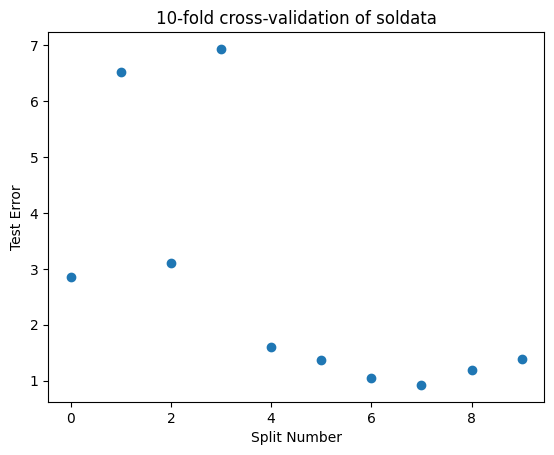

In [3]:
k = 10
N = len(soldata)
# make indices for the k segments
splits = list(range(0, N + N // k, N // k))
error = []
for i in range(k):
    # slice out segments
    test = soldata[splits[i] : splits[i + 1]]
    test_x, test_y = test[feature_names].values, test["Solubility"].values
    train = pd.concat([soldata[splits[i] :], soldata[splits[i + 1] :]])
    x, y = train[feature_names].values, train["Solubility"].values
    # compute coefficients
    w, *_ = np.linalg.lstsq(x, y)
    # compute intercept (b)
    b = np.mean(y - np.dot(x, w))
    # compute test erropr
    error.append(np.mean((np.dot(test_x, w) + b - test_y) ** 2))
plt.plot(error, "o")
plt.xlabel("Split Number")
plt.ylabel("Test Error")
plt.title(f"{k}-fold cross-validation of soldata")
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
from myst_nb import glue

glue("large_error", np.mean(error))
glue("large_error_std", np.std(error, ddof=1))

The final answer in this case is the average of these values: {glue:text}`large_error:.2f`$\pm${glue:text}`large_error_std:.2f`. The advantage of the k-fold is that we can report standard deviation like this.

Now what effect does k have on the test error? Let's see how our choice of k matters

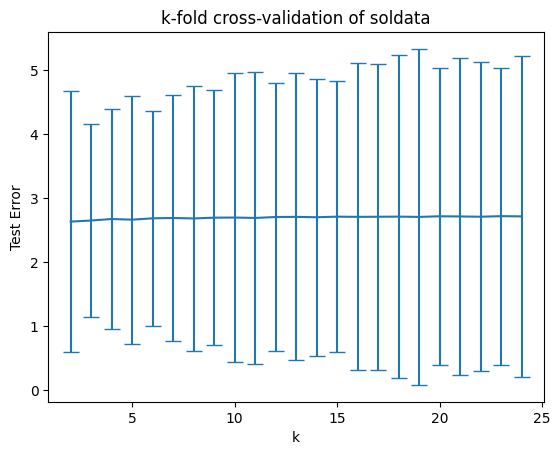

In [4]:
N = len(soldata)
error = []
error_std = []
for k in range(2, 25):
    splits = list(range(0, N + N // k, N // k))
    k_error = []
    for i in range(k):
        # slice out segments
        test = soldata[splits[i] : splits[i + 1]]
        test_x, test_y = test[feature_names].values, test["Solubility"].values
        train = pd.concat([soldata[splits[i] :], soldata[splits[i + 1] :]])
        x, y = train[feature_names].values, train["Solubility"].values
        # compute coefficients
        w, *_ = np.linalg.lstsq(x, y)
        # compute intercept (b)
        b = np.mean(y - np.dot(x, w))
        # compute test error
        k_error.append(np.mean((np.dot(test_x, w) + b - test_y) ** 2))
    error.append(np.mean(k_error))
    error_std.append(np.std(k_error, ddof=1))
plt.errorbar(range(2, 25), error, yerr=error_std, capsize=6)
plt.xlabel("k")
plt.ylabel("Test Error")
plt.title("k-fold cross-validation of soldata")
plt.show()

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
glue("kf-5", np.mean(error[3]))

As you can see, there is not much sensitivity to k. This is good, because k is mostly arbitrary. Larger k means more samples, but each test data is smaller so that these two effects should balance out.

Large datasets are not that sensitive because the training and testing splits are large. Let us examine what happens with $N = 25$, a realistic case in chemistry data. We'll just pick 25 data points at the beginning and not change that choice, mocking what would happen in a real example.

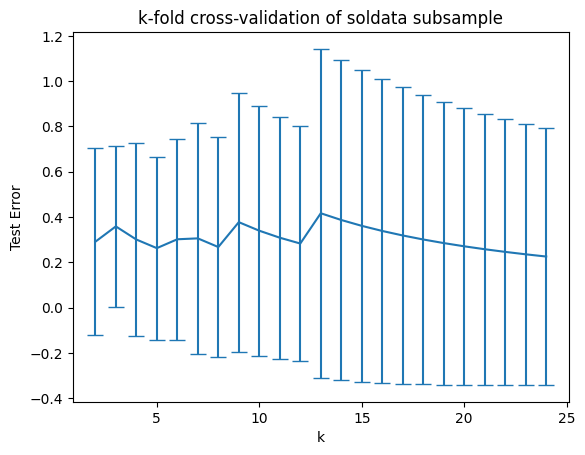

In [5]:
small_soldata = soldata.sample(25, replace=False)
N = len(small_soldata)
error = []
error_std = []
for k in range(2, 25):
    splits = list(range(0, N + N // k, N // k))
    k_error = []
    for i in range(k):
        # slice out segments
        test = small_soldata[splits[i] : splits[i + 1]]
        test_x, test_y = test[feature_names].values, test["Solubility"].values
        train = pd.concat([small_soldata[splits[i] :], small_soldata[splits[i + 1] :]])
        x, y = train[feature_names].values, train["Solubility"].values
        # compute coefficients
        w, *_ = np.linalg.lstsq(x, y)
        # compute intercept (b)
        b = np.mean(y - np.dot(x, w))
        # compute test erropr
        k_error.append(np.mean((np.dot(test_x, w) + b - test_y) ** 2))
    error.append(np.mean(k_error))
    error_std.append(np.std(k_error, ddof=1))
plt.errorbar(range(2, 25), error, yerr=error_std, capsize=6)
plt.xlabel("k")
plt.ylabel("Test Error")
plt.title("k-fold cross-validation of soldata subsample")
plt.show()

Our results are a little sensitive to the choice of $k$. Now why might test error decrease? Remember that a larger $k$ means *more* data points for training. This did not matter above when we had 10,000 data points. Now it is very importatnt, since we only have 25 data points. Thus larger k means more training data.


### Leave-one-out CV

Larger k means more training data, so what is the largest it can be? Remember that k is the number segments in your data. So $k = N$ is the max, where each data point is a segement. This is called **leave-one-out cross-validation** (LOOCV). It creates $N$ different models, one for each data point left out, and so is only used for small datasets. Thus the advantage of LOOCV is it maximizes training data, but maximizes the number of times the model needs to be trained.

## Computing Other Measures

Using LOOCV and k-fold cross-validation, we're able to predict test error. This "test error" is specifically an expected error on an unseen data point. Now how do we actually treat a new data point? What will we report as the certainty in a new point? The test error? We'll call this point the **prediction point** and we'll try to estimate the quantiles of this point. Quantiles are the building blocks for confidence intervals. Recall that confidence intervals allow us to report our model prediction as $4.3 \pm 0.2$, for example.

```{margin}
Classically bootstrap resampling and **jacknife**, its predecessor, are used for estimating variance in model parameters (i.e., model variance). However, they are more commonly used in ML for predicting confidence intervals and/or test error for new points (also called generalization error).
```


### Bootstrap Resampling

To estimate quantiles, we need to have a series of observations of predictions from the prediction point $\hat{f}(\vec{x}')$, where $\vec{x}'$ is the prediction point. For example, we could do 5-fold cross-validation and have 5 estimates of $\hat{f}_k(\vec{x}')$ and could estimate the quantiles using a t-statistic. Instead, we'll use a method called **bootstrap resampling** which removes the restriction that we can only use $1 - 1 / k$ of the training data. Bootstrap resampling is a general process for estimating uncertainty for empirical statistics without assuming a probability distribution (i.e., non-parametric). In bootstrap resampling, we create as many as desired new training datasets that are the same size as the original by sampling **with replacement** from the original dataset. That means our new dataset has fewer members than the original and makes up the difference with duplicates. Let's see an example. If your training dataset originally has data A, B, C, D, E, our bootstrap resampled training data is:

1. A, B, B, D, E
2. B, C, C, C, E
3. A, B, D, E, E
4. A, B, C, D, E
5. A, A, C, C, D

and so forth. The "with replacement" means that we allow repeats. This gives some variation to our training data. It also means we can generate $2^N$ new datasets, which is practically as many as we want. Let's see now how we could use this to quantile the estimate for a prediction on a test point. We'll set $N = 1000$ and do bootstrap resampling for 100 iterations.

In [6]:
# Create training data and 1 test point
N = 1000
# this line gets the data for our example
# it is not the bootstrap resampling
tmp = soldata.sample(N + 1, replace=False)
small_soldata = tmp.iloc[:N]
predict_point = tmp.iloc[-1]

In [7]:
samples = 100
predictions = []
for i in range(samples):
    # choose with replacement indices to make new dataset
    idx = np.random.choice(np.arange(N), size=N, replace=True)
    train = small_soldata.iloc[idx]
    x, y = train[feature_names].values, train["Solubility"].values
    # compute coefficients
    w, *_ = np.linalg.lstsq(x, y)
    # compute intercept (b)
    b = np.mean(y - np.dot(x, w))
    # compute test prediction
    predictions.append(np.dot(predict_point[feature_names].values, w) + b)
# compute quantiles (lower, median, upper)
qint = np.quantile(predictions, [0.025, 0.5, 0.975])
# compute avg distance from median to report +/-
print(
    f'prediction = {qint[1]:.2f} +/- {(qint[-1] - qint[0]) / 2:.2f}, label = {predict_point["Solubility"]:.2f}'
)

prediction = -5.66 +/- 0.34, label = -5.62


The resulting prediction has confidence intervals, thanks to the bootstrap resampling. This approach has a few disadvantages though. The first is that we need to produce and keep 100 models, one for each bootstrap resample. Of course you could choose fewer, but you need to have enough for good statistics.

Another issue is that this process does not give a reportable test error. We could further split our data again and do k-fold cross-validation on this approach to get test error. However, this is a bit overly complex and then we'll be at a similar problem that we'll have k sets of 100 models and it's not obvious how to combine them. These prediction intervals also under-estimate the model bias, because it has no estimate of the test error. It only accounts for variation due to training data. Using the language above, it only accounts for model variance but not model bias.

Bootstrap resampling is still an excellent technique that is used often to estimate uncertainties. However, it is not a great choice for estimating model error on unseen datapoints.

### Jacknife+


```{margin}
There is a method called Jacknife, which does not compute multiple predictions. It computes the residuals as mentioned above, but it trains one final model on all data. Since it requires you to compute all $N$ models to get the residuals, it is preferred to just use Jacknife+ which is more robust.
```

An alternative approach that accounts for model variance like the bootstrap method and model bias like the k-fold cross-validation method is called **Jacknife+** {cite}`barber2019predictive`.  Jacknife+ carries strong guarantees about accuracy of the confidence intervals generated, regardless of the underlying data or model. The change now is that we use LOOCV to create an ensemble of models (although you can subsample down if you do not want N of them) and also compute the models' test error on the withheld test data. The final quantile estimates incorporate the variance from the variety of models (model variance) and also each models' individual test error (model bias).
Specifically, we compute:

\begin{equation}
R_i = \left|y_i - \hat{f}(\vec{x}_i;\,\mathbf{X} \setminus \vec{x}_i )\right|
\end{equation}

where $\mathbf{X} \setminus \vec{x}_i$ is the dataset to train the $i$th model and is the dataset excluding point $(\vec{x}_i, y_i)$, $\hat{f}(\vec{x}_i;\,\mathbf{X} \setminus \vec{x}_i ) $ is the $i$th model evaluated on point $\vec{x}_i$, and $R_i$ is the residual of model $i$ computed by taking the difference between the label and prediction on point $i$. $R_i$ encodes how good the $i$th model is. We then combine it with the predictions on our new test point $(\vec{x}', y')$ to make our set for quantiling


\begin{equation}
q_1 = \left\{ \hat{f}(\vec{x}';\,\mathbf{X} \setminus \vec{x}_i ) - R_i\right\}
\end{equation}

\begin{equation}
q_2 = \left\{\hat{f}(\vec{x}';\,\mathbf{X} \setminus \vec{x}_i ) + R_i\right\}
\end{equation}

where $q$ means quantile. The first quantile $q_1$, with $ - R_i$, is how low below the estimate from the $i$th model we could expect to see our prediction based on how the $i$th model did on its test point. The second set, with $ + R_i$, is how high above the estimate from the $i$th model we could expect to see our prediction based on how the $i$th model did on its test point. To compute our final value, we take the median of $\hat{f}(\vec{x}';\,\mathbf{X} \setminus \vec{x}_i )$ and report the lower end of the interval as the 5% quantile of $q_1$ and the top as the 95% quantile of $q_2$. You can see that this method combines the ensemble of prediction models given by bootstrap resampling with the error estimates from LOOCV. Let's see an example.


In [8]:
residuals = []
predictions = []
for i in range(N):
    # make train excluding test point
    # we just make a set and remove one element from it
    # and then convert back to list
    idx = list(set(range(N)) - set([i]))
    train = small_soldata.iloc[idx]
    x, y = train[feature_names].values, train["Solubility"].values
    # compute coefficients
    w, *_ = np.linalg.lstsq(x, y)
    # compute intercept (b)
    b = np.mean(y - np.dot(x, w))
    # compute test prediction
    predictions.append(np.dot(predict_point[feature_names].values, w) + b)
    # now compute residual on withtheld point
    yhat = np.dot(small_soldata.iloc[idx][feature_names].values, w) + b
    residuals.append(np.abs(yhat - small_soldata.iloc[idx]["Solubility"]))
# create our set of prediction - R_i and prediction + R_i
q1 = [p - ri for p, ri in zip(predictions, residuals)]
q2 = [p + ri for p, ri in zip(predictions, residuals)]
# compute quantiles (lower, median, upper)
qlow = np.quantile(q1, [0.05])[0]
qhigh = np.quantile(q2, [0.95])[0]
# compute avg distance from medianto report +/-
print(
    f'prediction = {np.median(predictions):.2f} +/- {(qlow - qhigh) / 2:.2f}, label = {predict_point["Solubility"]:.2f}'
)
print(f"Average test error = {np.median(residuals):.2f}")

prediction = -5.58 +/- -3.32, label = -5.62
Average test error = 1.05


The uncertainty is much higher, which is likely closer to reality. You can see that the residuals add about 1 solubility (model variance) unit and the variability in the data (label noise) adds about 2 solubility units. Jacknife+ should be the preferred method when you have small datasets (1-1000) and can train models quickly enough to be able to compute 1000 of them. You can also replace the exhaustive LOOCV with a random process, where you only do a few iterations (like 25) of LOOCV to avoid computing so many models.

##  Training Data Distribution

We have come a long ways now. We're able to compute test error, identify overfitting, understand model bias and variance, and predict uncertainty on unseen data points. One of the implied assumptions so far is that our splitting of data into training and testing data mimics what it will be like to predict on an unseen data point. More specifically, we assume that testing data comes from the same probability distribution as our training data. This is true when we're doing the splitting, but is often violated when we actually get new data to make predictions with.

There are specific categories for how we have left the training distribution. **Covariate shift** is when the distribution of features changes. Covariate is another word for features. An example might be that the molecular weights of your molecules are larger in your testing data. The relationship between features and labels, $f(\vec{x})$ remains the same, but the distribution of features is different. **Label shift** means that the distribution of labels has changed. Perhaps our training data was all very soluble molecules but at test time, we're examining mostly insoluble molecules. Again, our fundamental relationship  $f(\vec{x})$ that we try to estimate with our model still holds.

```{margin} Applicability Domain
Applicability domain is a term from cheminformatics describing
avoiding covariate shift by trying to stay within the training data distribution.
```

There are two common reasons unseen data can be out of the training data distribution. The first is that you are extrapolating to new regions of chemical space. For example, you have training data of drug activities. You make a model that can predict activity. What do you do with the model? You obviously find the highest activity drug molecule. However, this molecule is likely to be unusual and not in your training data. If it was in your training data you would probably already be done -- namely, you already synthesized and found a molecule with very high activity. Thus you will be pushing your model to regions outside of your training data. Another reason you can be out of training data is that the way you generated training data is different than how the model is used. For example, perhaps you trained on molecules that do not contain fluorine. Then you try your model on molecules that contain fluorine. Your features will be different than what you observed in training. The result of leaving your training data distribution is that your test error increases and the estimates you provide will be too low.




### Leave One Class Out Cross-Validation

Thus understanding and assessing training data distribution is an important task. In general, standard models that minimize a loss are poor at predicting extreme values. We will approach this challenge later with specific methods like black-box function optimization. For now, be wary of using your models as tools to find extreme values. The second challenge, that you're leaving your training data due to how points are generated, can be assessed by computing a more realistic estimate of model error. Namely, your training data is typically gathered (generated) according to a different process than when your model is deployed at test time. This is generalization error, sometimes called **covariate shift**, and we sometimes wish to approximate its effect by simulating different training and testing distributions. This leads us to **leave one class out cross-validation** (LOCOCV).

In LOCOCV, we must first assign a class to each training data point. This is domain specific. It could be based on the molecule. You could use a clustering method. In our case, our solubility data actually is a combination of five other datasets so our data is already pre-classified based on who measured the solubility. We will now perform a kind of k-fold cross-validation, leaving one class out at a time and assessing model error. We'll compare this to k-fold cross-validation without classes.


In [9]:
# let's see what the groups (classes) are
unique_classes = soldata["Group"].unique()
print(unique_classes)

['G1' 'G3' 'G5' 'G4' 'G2']


In [10]:
# Leave one class out CV
N = len(soldata)
error = []
error_std = []
for c in unique_classes:
    # slice out segments
    test = soldata.loc[soldata["Group"] == c]
    train = soldata.loc[soldata["Group"] != c]
    test_x, test_y = test[feature_names].values, test["Solubility"].values
    x, y = train[feature_names].values, train["Solubility"].values
    # compute coefficients
    w, *_ = np.linalg.lstsq(x, y)
    # compute intercept (b)
    b = np.mean(y - np.dot(x, w))
    # compute test erropr
    k_error.append(np.mean((np.dot(test_x, w) + b - test_y) ** 2))
    error.append(np.mean(k_error))
    error_std.append(np.std(k_error, ddof=1))
print(f"test error = {np.mean(error):.2f}")

test error = 0.58


In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
glue("lococv", np.mean(error), display=False)

We computed above what the 5-fold cross-validation is for this data, {glue:text}`kf-5:.2f`. You can see the LOCOCV test error ({glue:text}`lococv:.2f`) is similar, which means our different data sources agree well. So perhaps on new unseen data we can expect similar (not so great) accuracy. There may be other ways to group this data into classes, like based on molecular weight or which atoms are contained in the molecule. It depends on what you believe to be important. Breaking it down into the constituent datasets, like we did above, is a reasonable approach because it captures how different research groups would measure solubility. It is not always obvious or possible to use LOCOCV, but it should be something you consider to assess out of training data distribution. You can read more about the issue of leaving training data distribution for materials in this recent article {cite}`sutton2020identifying`. You can read more about model selection in general in this recent tutorial article {cite}`raschka2018model`.

## Chapter Summary

* Regression is supervised learning where the labels are real numbers. We only considered scalars
* To assess a regressed model, we split data into training and testing and only report error on testing data
* Overfitting causes a mismatch between training and testing error
* Overfitting can be understood via the bias-variance decomposition
* Increasing model complexity can improve fit (reduce bias), but increases model variance and thus test error
* Regularization is a strategy to decrease model variance. L2 is a good first choice
* More rigorous assessment of models can be done via k-fold cross-validation or Jacknife+ when the training data is small enough that we can train multiple models
* Much of our model assessments depends on the testing data being from the same distribution as the training data (similar values). This is often not true and can be measured with leave-one-class-out cross-validation.


## Exercises

### Overfitting

1. What happens if we have redundant features but no noise? Is it possible to overfit?
2. We said that increasing dataset size reduces model variance. Show this by using k-fold cross-validation on a few different dataset sizes.

### Regularization

1. Implement L1 regularization on the solubility data with $N = 35$ data points. Increase the strength until some feature coefficients ($w_i$) go to zero. Which ones are they? Why do you think they go to zero first?
2. Repeat 1 with a few different sets of training data. Are your results consistent on which features disappear? Based on your results, do you think there is meaning to the features which go to zero?
3. Implement the L-infinity (supremum norm) regularization, which returns the maxmium of the absolute values of the elements.

### Model Assessment

1. Develop the best linear model for the complete solubility dataset and assess using your best judgment. Justify your choice of model and assessment.


## Solution to Overfitting Exercise

1. Adding redundant features with no noise in the training label will not cause overfitting.

In [20]:
# Prepare full X and y
X_full = soldata[feature_names].to_numpy()
y_full = soldata["Solubility"].to_numpy()
X_full, y_full

(array([[392.51      ,   3.9581    , 102.4454    , ..., 158.52060059,
           0.        , 210.37733409],
        [169.183     ,   2.4055    ,  51.9012    , ...,  75.1835629 ,
           2.58299639, 511.22924772],
        [140.569     ,   2.1525    ,  36.8395    , ...,  58.26113356,
           3.00978195, 202.6610651 ],
        ...,
        [150.221     ,   2.82402   ,  46.9328    , ...,  67.68540533,
           3.09271976, 251.04973179],
        [454.611     ,   5.09308   , 131.656     , ..., 198.56922331,
           2.02333342, 938.203977  ],
        [308.333     ,   3.6096    ,  87.7318    , ..., 132.55202509,
           2.25807247, 909.55097269]]),
 array([-3.61612712, -3.2547671 , -2.17707794, ..., -2.19      ,
        -3.98      , -4.78      ]))

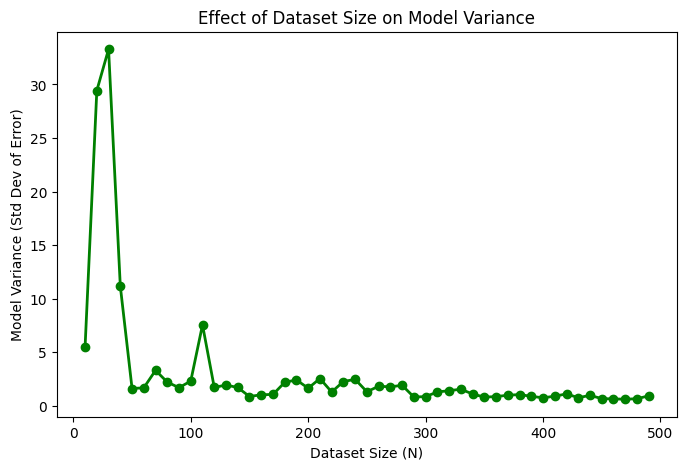

In [14]:
# Dataset sizes to test
sizes = range(10,500,10)
variance_results = []

for N in sizes:
    subset = soldata.sample(N, random_state=0)
    X_subset = subset[feature_names].to_numpy()
    y_subset = subset["Solubility"].to_numpy()

    # Cross-validation 10 folds
    k = 10
    step = N // k
    splits = list(range(0, N + step, step))

    fold_errors = []

    # Loop through each fold
    for i in range(k):
        start_idx = splits[i]
        end_idx = splits[i+1]

        X_test = X_subset[start_idx : end_idx]
        y_test = y_subset[start_idx : end_idx]

        X_train = np.concatenate([X_subset[:start_idx], X_subset[end_idx:]])
        y_train = np.concatenate([y_subset[:start_idx], y_subset[end_idx:]])

        # Standardize
        mu = X_train.mean(axis=0)
        sigma = X_train.std(axis=0)
        X_train_scaled = (X_train - mu) / (sigma + 1e-8) # Add 1e-8 to avoid dividing by 0
        X_test_scaled = (X_test - mu) / (sigma + 1e-8)

        # lstsq finds the best fitting line
        w, *_ = np.linalg.lstsq(X_train_scaled, y_train, rcond=None)

        # compute intercept (b)
        b = np.mean(y_train - np.dot(X_train_scaled, w))

        preds = X_test_scaled @ w + b # Predictions on test Data

        # MSE Loss
        mse = np.mean((y_test - preds)**2)
        fold_errors.append(mse)

    variance = np.std(fold_errors)
    variance_results.append(variance)

# Visualize
plt.figure(figsize=(8, 5))
plt.plot(sizes, variance_results, 'o-', linewidth=2, color='green')
plt.xlabel("Dataset Size (N)")
plt.ylabel("Model Variance (Std Dev of Error)")
plt.title("Effect of Dataset Size on Model Variance")
plt.grid(False)
plt.show()

## Solution to Regularization Exercise

In [16]:
@jax.jit
def l1_loss(w, b, x, y, alpha): # L1 Loss & Gradient
    pred = x @ w + b
    mse = jnp.mean((y - pred) ** 2)
    reg = alpha * jnp.sum(jnp.abs(w)) # L1 Penalty
    return mse + reg

l1_grad = jax.jit(jax.grad(l1_loss, argnums=(0, 1)))

# Gradient Descent Training Loop
def train_l1(x, y, alpha, steps=5000, eta=0.01):
    # Initialize tiny random weights
    key = jax.random.PRNGKey(0)
    w = jax.random.normal(key, (x.shape[1],)) * 0.01
    b = 0.0

    for i in range(steps):
        dw, db = l1_grad(w, b, x, y, alpha)
        w -= eta * dw
        b -= eta * db
    return w

N = 35
subset = soldata.sample(N, random_state=0)
X_sub = subset[feature_names].to_numpy()
y_sub = subset["Solubility"].to_numpy()
# Standardize
mu = X_sub.mean(axis=0)
sigma = X_sub.std(axis=0) + 1e-8
X_std = (X_sub - mu) / sigma

# Sweep alphas
alphas = [0.0, 0.1, 0.5, 0.8, 1.0, 1.5]
print(f"L1 Feature Dropout (N={N})")

for a in alphas:
    w = train_l1(X_std, y_sub, alpha=a)

    zero_mask = jnp.abs(w) < 0.01 # Zero features magnitude < 0.01
    dropped_cols = feature_names[zero_mask]

    print(f"Alpha = {a:.1f} | Dropped: {len(dropped_cols)}")
    if len(dropped_cols) > 0:
        print(f"   -> {list(dropped_cols)}")

L1 Feature Dropout (N=35)
Alpha = 0.0 | Dropped: 0
Alpha = 0.1 | Dropped: 9
   -> ['HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'LabuteASA']
Alpha = 0.5 | Dropped: 14
   -> ['MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']
Alpha = 0.8 | Dropped: 14
   -> ['MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']
Alpha = 1.0 | Dropped: 9
   -> ['HeavyAtomCount', 'NumHAcceptors', 'NumValenceElectrons', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'BalabanJ', 'BertzCT']
Alpha = 1.5 | Dropped: 7
   -> ['HeavyAtomCount', 'NumHAcceptors', 'NumHDono

In [17]:
seeds = [10, 20, 40]
check_alpha = 0.8

for s in seeds:
    sub = soldata.sample(35, random_state=s)
    X_s = sub[feature_names].to_numpy()
    y_s = sub["Solubility"].to_numpy()
    # Standardize
    X_s_std = (X_s - X_s.mean(axis=0)) / (X_s.std(axis=0) + 1e-8)
    # Train
    w = train_l1(X_s_std, y_s, alpha=check_alpha)
    # Check drops
    dropped = feature_names[jnp.abs(w) < 0.01]
    print(f"Seed {s}: Dropped {list(dropped)}")

Seed 10: Dropped ['MolWt', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'TPSA', 'BalabanJ', 'BertzCT']
Seed 20: Dropped ['HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']
Seed 40: Dropped ['MolWt', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ']


## Solution to Model Assessment

In [21]:
# Function to solve Ridge Regression
def fit_ridge_regression(x, y, alpha):
    size = x.shape[1]
    identity = np.eye(size) * alpha # Identity matrix scaled by alpha
    # Solve the linear equation: (X.T * X + alpha * I) * w = X.T * y
    A = x.T @ x + identity
    B = x.T @ y
    w = np.linalg.solve(A, B)
    b = np.mean(y - x @ w)
    return w, b

# 10-Fold Cross Validation
k = 10
total_points = len(y_full)
fold_size = total_points // k
splits = list(range(0, total_points + fold_size, fold_size))
rmse_scores = []
alpha = 10.0 # Regularization Strength

for i in range(k):
    start = splits[i]
    end = splits[i+1]
    # Test Set
    test_features = X_full[start:end]
    test_labels = y_full[start:end]
    # Training Set
    train_features = np.concatenate([X_full[:start], X_full[end:]])
    train_labels = np.concatenate([y_full[:start], y_full[end:]])
    # Standardize
    mu = train_features.mean(axis=0)
    sigma = train_features.std(axis=0) + 1e-8
    train_features_scaled = (train_features - mu) / sigma
    test_features_scaled = (test_features - mu) / sigma
    # Train the model
    w, b = fit_ridge_regression(train_features_scaled, train_labels, alpha)
    predictions = test_features_scaled @ w + b
    # rmse for fold
    mse = np.mean((test_labels - predictions)**2)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

# Calculate final average performance
average_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Final model rmse: {average_rmse:.3f} +/- {std_rmse:.3f}")

Final model rmse: 1.655 +/- 0.513


## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```